In [ ]:
## BG/NBD MODEL

In [473]:
# import packages for data manipulation
import pandas as pd
import numpy as np

# import packages for data visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import matplotlib.figure as figure

# import packages for CLV, churn
import lifetimes as lifetimes

In [474]:
# import transactional raw data
from pandas import read_excel

xls = pd.ExcelFile('online_retail_II.xlsx')
df1 = pd.read_excel(xls, 'Year 2009-2010')
df2 = pd.read_excel(xls, 'Year 2010-2011')

df_raw = df1.append(df2)
df_raw
# 1067371  

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [475]:
print (df_raw.isnull().any())

Invoice        False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
Price          False
Customer ID     True
Country        False
dtype: bool


In [476]:
# filter out rows will null Customer ID as RFM metrics must be calculated per customer
df_raw = df_raw[df_raw['Customer ID'].notnull()]
df_raw

# 824364   

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [477]:
# check data types
result = df_raw.dtypes

print("Data Types:")
print(result)

Data Types:
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object


In [478]:
# rename column
df_raw.rename(columns = {'StockCode':'sku'}, inplace = True)
df_raw.rename(columns = {'Description':'description'}, inplace = True)


# remove rows with negative values in Quantity column, pertaining to returned orders
df_raw = df_raw[(df_raw['Quantity'] > 0)]

# remove rows with missing CustomerID as our analysis will be at the individual customer level
df_raw.dropna(axis = 0, subset = ['Customer ID'], inplace = True)

# format customer number into a string
df_raw['customerid'] = df_raw['Customer ID'].apply(lambda x: int(x))
df_raw['customerid'] = df_raw['customerid'].astype(str)

# format order date into datetime
df_raw['orderdt'] = pd.to_datetime(df_raw['InvoiceDate']).dt.date

# create a new column for Order Amount as per invoice based on quantity and price 
df_raw['orderamt'] = df_raw['Quantity'] * df_raw['Price']

# select columns for the analyses
df = df_raw[['customerid', 'sku', 'description', 'orderdt', 'orderamt']]

# check data types
result = df.dtypes
print("Data Types:")
print(result)

df
#805620  

Data Types:
customerid      object
sku             object
description     object
orderdt         object
orderamt       float64
dtype: object


,customerid,sku,description,orderdt,orderamt
0,13085,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,2009-12-01,83.40
1,13085,79323P,PINK CHERRY LIGHTS,2009-12-01,81.00
2,13085,79323W,WHITE CHERRY LIGHTS,2009-12-01,81.00
3,13085,22041,"RECORD FRAME 7"" SINGLE SIZE",2009-12-01,100.80
4,13085,21232,STRAWBERRY CERAMIC TRINKET BOX,2009-12-01,30.00
...,...,...,...,...,...
541905,12680,22899,CHILDREN'S APRON DOLLY GIRL,2011-12-09,12.60
541906,12680,23254,CHILDRENS CUTLERY DOLLY GIRL,2011-12-09,16.60
541907,12680,23255,CHILDRENS CUTLERY CIRCUS PARADE,2011-12-09,16.60
541908,12680,22138,BAKING SET 9 PIECE RETROSPOT,2011-12-09,14.85


In [479]:
print(df.isnull().any())


customerid     False
sku            False
description    False
orderdt        False
orderamt       False
dtype: bool


In [480]:
# check min and max date to indicate calibration and observation windows 

mindate = min(df.orderdt)
print("Min Date:")
print(mindate)
#2009-12-01

maxdate = max(df.orderdt)
print("Max Date:")
print(maxdate)
#2011-12-09

Min Date:
2009-12-01
Max Date:
2011-12-09


In [481]:
# derive rfm; calculations set to weekly basis, predictions done later will be for future n weekly periods too
from lifetimes.utils import summary_data_from_transaction_data

rfm = summary_data_from_transaction_data(transactions=df,
                                         customer_id_col='customerid',
                                         datetime_col='orderdt',
                                         monetary_value_col = 'orderamt',
                                         freq='D')

onetimebuyers = round(sum(rfm['frequency']==0)/float(len(rfm))*(100),2)
print("Percentage of customers who purchase only once:", onetimebuyers,"%")


# Remove the one-time buyers. There is not enough history (only 1 data point/purchase) to use for prediction for future purchases.
# Based on the paper on BG/NBD model ("Counting Your Customers" the Easy Way, "the BG/NBD model forecasts tend to be relatively poor when penetration and/or purchase frequency are extremely low.
# In a world where active buyers are either uncommon or very slow in making their purchases, BG/NBD will be outperformed by the Pareto/NBD model. In this case, the one-time buyers (~28% of customers) were removed before fitting the models. 
# Pareto/NBD model should be fitted and compared.

# 4189   customers
rfm

Percentage of customers who purchase only once: 28.77 %


,frequency,recency,T,monetary_value
customerid,,,,
12346,7.0,400.0,725.0,11066.637143
12347,7.0,402.0,404.0,717.398571
12348,4.0,363.0,438.0,449.310000
12349,3.0,571.0,589.0,1120.056667
12350,0.0,0.0,310.0,0.000000
...,...,...,...,...
18283,18.0,655.0,658.0,146.405556
18284,0.0,0.0,431.0,0.000000
18285,0.0,0.0,660.0,0.000000


In [482]:
# summary description of the variables

rfm.describe()[['frequency', 'recency', 'T', 'monetary_value']]

# average frequency is ~ 6 - 7 
# however, notice that 75% percentile is 7 and max is 101. 
# there are outliers with customers who have purchased more frequently. We will look at the distributions for each variable below

,frequency,recency,T,monetary_value
count,5881.000000,5881.000000,5881.000000,5881.000000
mean,4.630335,273.254208,474.247067,318.883972
std,10.001176,258.971689,223.142456,2256.282323
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,313.000000,0.000000
50%,2.000000,220.000000,530.000000,213.470200
75%,5.000000,512.000000,668.000000,376.086667
max,254.000000,738.000000,738.000000,168469.600000


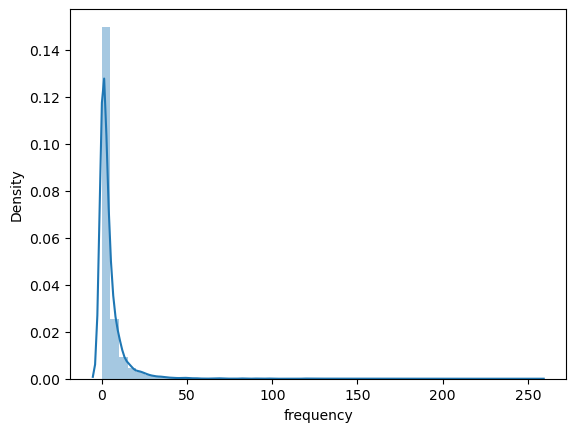

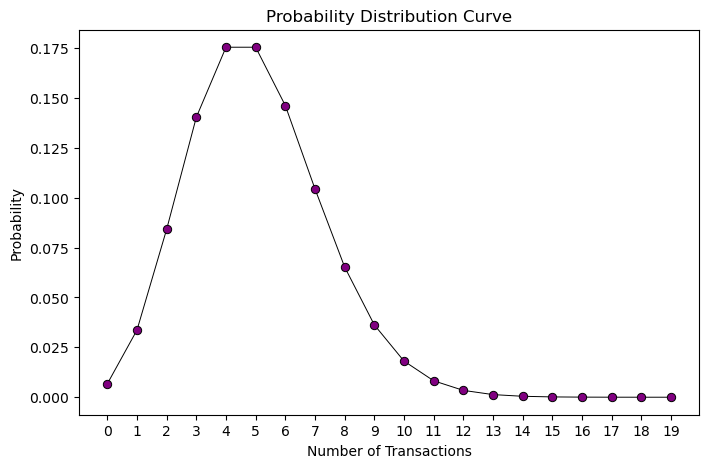

In [483]:
# check data distribution for frequency
dplotr = sns.distplot(rfm['frequency'])

import matplotlib.pyplot as plt
from scipy.stats import poisson

probability_arr = []
distribution = poisson(5)
for transactions in range(0,20):
     probability_arr.append(distribution.pmf(transactions))

plt.figure(figsize=(8,5))
plt.ylabel('Probability')
plt.xlabel('Number of Transactions')
plt.xticks(range(0, 20))
plt.title('Probability Distribution Curve')
plt.plot(probability_arr, color='black', linewidth=0.7, zorder=1)
plt.scatter(range(0, 20), probability_arr, color='purple', edgecolor='black', linewidth=0.7, zorder=2)
plt.show()


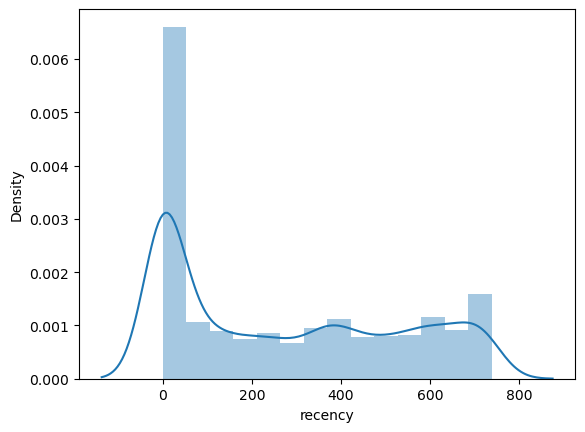

In [484]:
# check data distribution for recency
dplotr = sns.distplot(rfm['recency'])

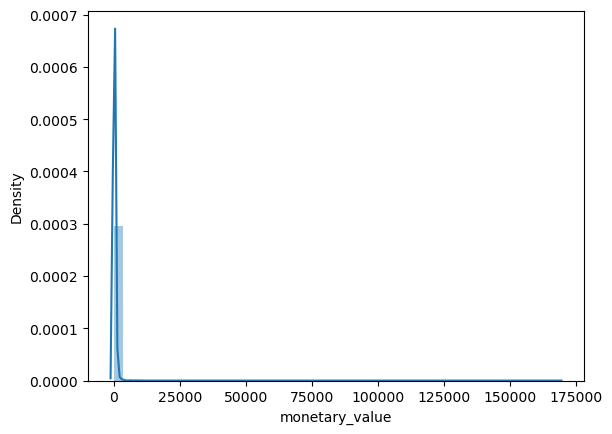

In [485]:
# check data distribution for monetary value
dplotm = sns.distplot(rfm['monetary_value'])

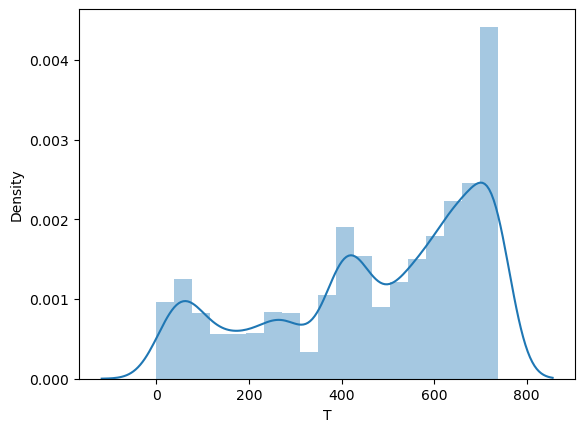

In [486]:
# check data distribution for customer tenure
dplott = sns.distplot(rfm['T'])

In [487]:
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_transaction_rate_heterogeneity
from lifetimes.plotting import plot_dropout_rate_heterogeneity
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix


# fit the BG/NBD model to our data_summary
bgf = BetaGeoFitter()
bgf.fit(rfm['frequency'], rfm['recency'], rfm['T'])

bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.662732,0.015825,0.631715,0.693749
alpha,63.184460,1.934702,59.392443,66.976476
a,0.108660,0.015446,0.078387,0.138934
b,2.418366,0.524988,1.389391,3.447342


In [488]:
# Compute the customer alive probability
rfm['p_alive'] = bgf.conditional_probability_alive(rfm['frequency'], rfm['recency'], rfm['T'])
rfm.head()

# sns.distplot(rfmggf['p_alive']);

,frequency,recency,T,monetary_value,p_alive
customerid,,,,,
12346,7.0,400.0,725.0,11066.637143,0.568660
12347,7.0,402.0,404.0,717.398571,0.986837
12348,4.0,363.0,438.0,449.310000,0.959046
12349,3.0,571.0,589.0,1120.056667,0.973475
12350,0.0,0.0,310.0,0.000000,1.000000


In [489]:
#Predict future transaction for the next t periods based on historical dataa
t = 30
rfm['p_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, rfm['frequency'], rfm['recency'], rfm['T']),2)
rfm.sort_values(by='p_num_txn', ascending=False).head(10).reset_index()

,customerid,frequency,recency,T,monetary_value,p_alive,p_num_txn
0,14911,254.0,737.0,738.0,1162.358268,0.999416,9.51
1,12748,202.0,735.0,735.0,279.101436,0.999466,7.60
2,15311,195.0,738.0,738.0,594.605846,0.999447,7.31
3,17841,192.0,736.0,737.0,366.423490,0.999286,7.20
4,14606,180.0,735.0,736.0,170.255889,0.999250,6.76
5,13089,131.0,735.0,737.0,888.318779,0.998860,4.92
6,14527,120.0,735.0,737.0,223.904250,0.998791,4.51
7,14156,120.0,729.0,738.0,2607.329750,0.996514,4.49
8,12971,98.0,721.0,724.0,162.360612,0.998410,3.75
9,13798,98.0,730.0,731.0,768.906837,0.998764,3.71


In [490]:
# MODEL VALIDATION
# split data to calibration and holdout date to train and validate the model

from lifetimes.utils import calibration_and_holdout_data

rfm_cal_holdout = calibration_and_holdout_data(transactions=df,
                                               customer_id_col='customerid', 
                                               datetime_col='orderdt',
                                               monetary_value_col = 'orderamt',
                                               freq='D',
                                               calibration_period_end='2011-06-30',
                                               observation_period_end='2011-12-09')


rfm_cal_holdout = rfm_cal_holdout[rfm_cal_holdout['frequency_cal'] > 0]

rfm_cal_holdout

# 3392     

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customerid,,,,,,,
12346,7.0,400.0,563.0,11066.637143,0.0,0.000000,162.0
12347,4.0,221.0,242.0,729.435000,3.0,26.300625,162.0
12348,3.0,190.0,276.0,495.746667,1.0,103.333333,162.0
12349,2.0,182.0,427.0,801.310000,1.0,24.076027,162.0
12352,5.0,130.0,230.0,352.372000,3.0,20.090000,162.0
...,...,...,...,...,...,...,...
18280,1.0,117.0,232.0,180.600000,0.0,0.000000,162.0
18281,1.0,397.0,415.0,80.820000,0.0,0.000000,162.0
18283,11.0,489.0,496.0,125.727273,7.0,3.032203,162.0


In [491]:
# train the model on the calibration data

# instantiation of BG-NBD model
bgf_cal = BetaGeoFitter(penalizer_coef=0.0)

# fit the BG-NBD model on the calibration data
bgf_cal.fit(frequency=rfm_cal_holdout['frequency_cal'], 
        recency=rfm_cal_holdout['recency_cal'], 
        T=rfm_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 3410 subjects, a: 0.15, alpha: 109.87, b: 1.24, r: 1.70>

In [492]:
# train the model on the calibration data

bgf_cal.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.703657,0.053611,1.598580,1.808735
alpha,109.868452,3.872866,102.277635,117.459269
a,0.149608,0.016927,0.116430,0.182785
b,1.242432,0.187778,0.874388,1.610476


In [493]:
# comparison of actual vs predicted number of transaction in the observation/holdout period
# the real number of transactions in the observation period, which equals frequency_holdout + 1
rfm_cal_holdout["n_transactions_holdout_real"]  = rfm_cal_holdout["frequency_holdout"] + 1

# the predicted number of transactions in the next t preiods (length of the observation period)
rfm_cal_holdout["n_transactions_holdout_pred"] = bgf.predict(t=161, 
                                                    frequency=rfm_cal_holdout['frequency_cal'], 
                                                    recency=rfm_cal_holdout['recency_cal'], 
                                                    T=rfm_cal_holdout['T_cal'])

# comparison of the real and predicted transactions
rfm_cal_holdout[["n_transactions_holdout_real", "n_transactions_holdout_pred"]].head(30)

,n_transactions_holdout_real,n_transactions_holdout_pred
customerid,,
12346,1.0,1.722955
12347,4.0,2.341689
12348,2.0,1.591286
12349,2.0,0.718575
12352,4.0,2.576477
12353,1.0,0.803658
12355,1.0,0.535193
12356,2.0,2.095710
12358,3.0,0.612894


In [494]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(y_true = rfm_cal_holdout["n_transactions_holdout_real"],
                          y_pred = rfm_cal_holdout["n_transactions_holdout_pred"],
                          squared = False)

RMSE

2.1650912131683278

<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

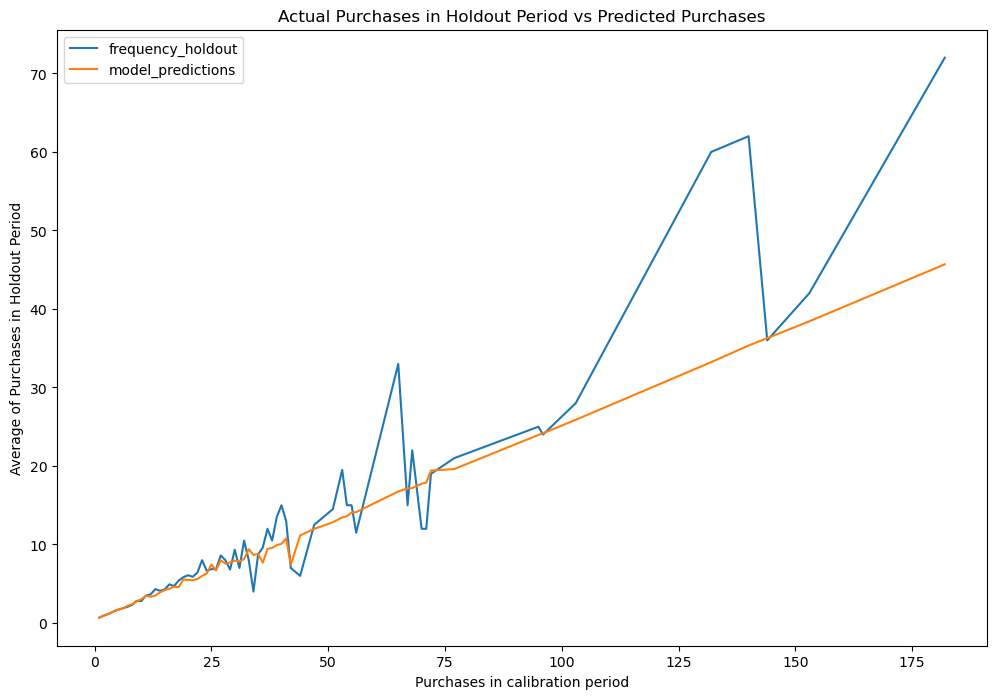

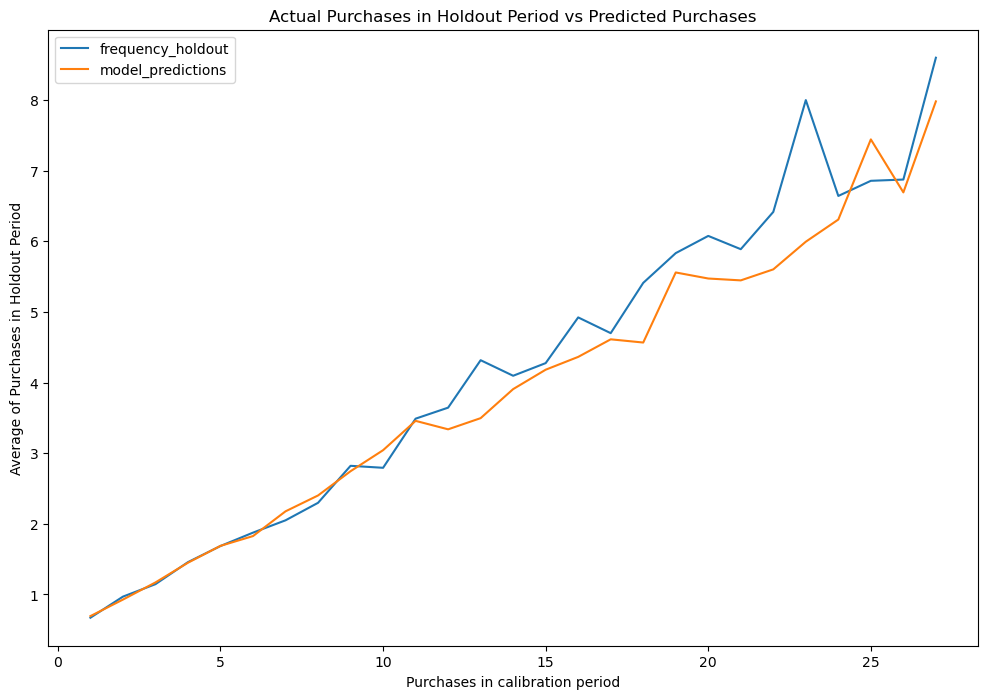

In [495]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

# plot actual vs predicted frequency during the holdout period
plot_calibration_purchases_vs_holdout_purchases(
    bgf, rfm_cal_holdout, n = int(rfm_cal_holdout['frequency_holdout'].max()),figsize = (12,8))

# n represents the max frequency values to be plotted on the x-axis

# same plot - zoom up to n purchases in the calibration
lifetimes.plotting.plot_calibration_purchases_vs_holdout_purchases(bgf, rfm_cal_holdout,n=27, figsize = (12,8))

# Comment: The higher the frequency of purchase in the calibration period, the higher the frequency of purchase in the hold out period. 
# However, as the frequency reaches around 110, the purchases during the calibration period does not seems to have a pattern/relationship with the average purchase in the holdout period. 
# This is probably likely caused by a relatively low number of customers in our data with a large number of repeat purchases.

In [496]:
# Predictions

# the number of purchases one will make in k future periods
# the probability of one being active at the end of the observation period

# Choose a sample customer: 
sample_customer = rfm_cal_holdout.iloc[500] 

# Let's inspect his frequency, recency and T both for the calibration and observation periods:
sample_customer

frequency_cal                   13.000000
recency_cal                    558.000000
T_cal                          575.000000
monetary_value_cal             438.715385
frequency_holdout                7.000000
monetary_value_holdout          21.792409
duration_holdout               162.000000
n_transactions_holdout_real      8.000000
n_transactions_holdout_pred      3.368987
Name: 13269, dtype: float64

In [497]:
# This function calculates the conditional expected number of transactions in the given time length
n_transactions_pred = bgf.predict(t=23, # we set it to 23 weeks (the length of the observation period)
                                  frequency=sample_customer['frequency_cal'], 
                                  recency=sample_customer['recency_cal'], 
                                  T=sample_customer['T_cal'])

n_transactions_pred

0.48620328838829197

In [498]:
alive_prob = bgf.conditional_probability_alive(frequency=sample_customer['frequency_cal'], 
                                               recency=sample_customer['recency_cal'], 
                                               T=sample_customer['T_cal'])

alive_prob


array([0.98921918])

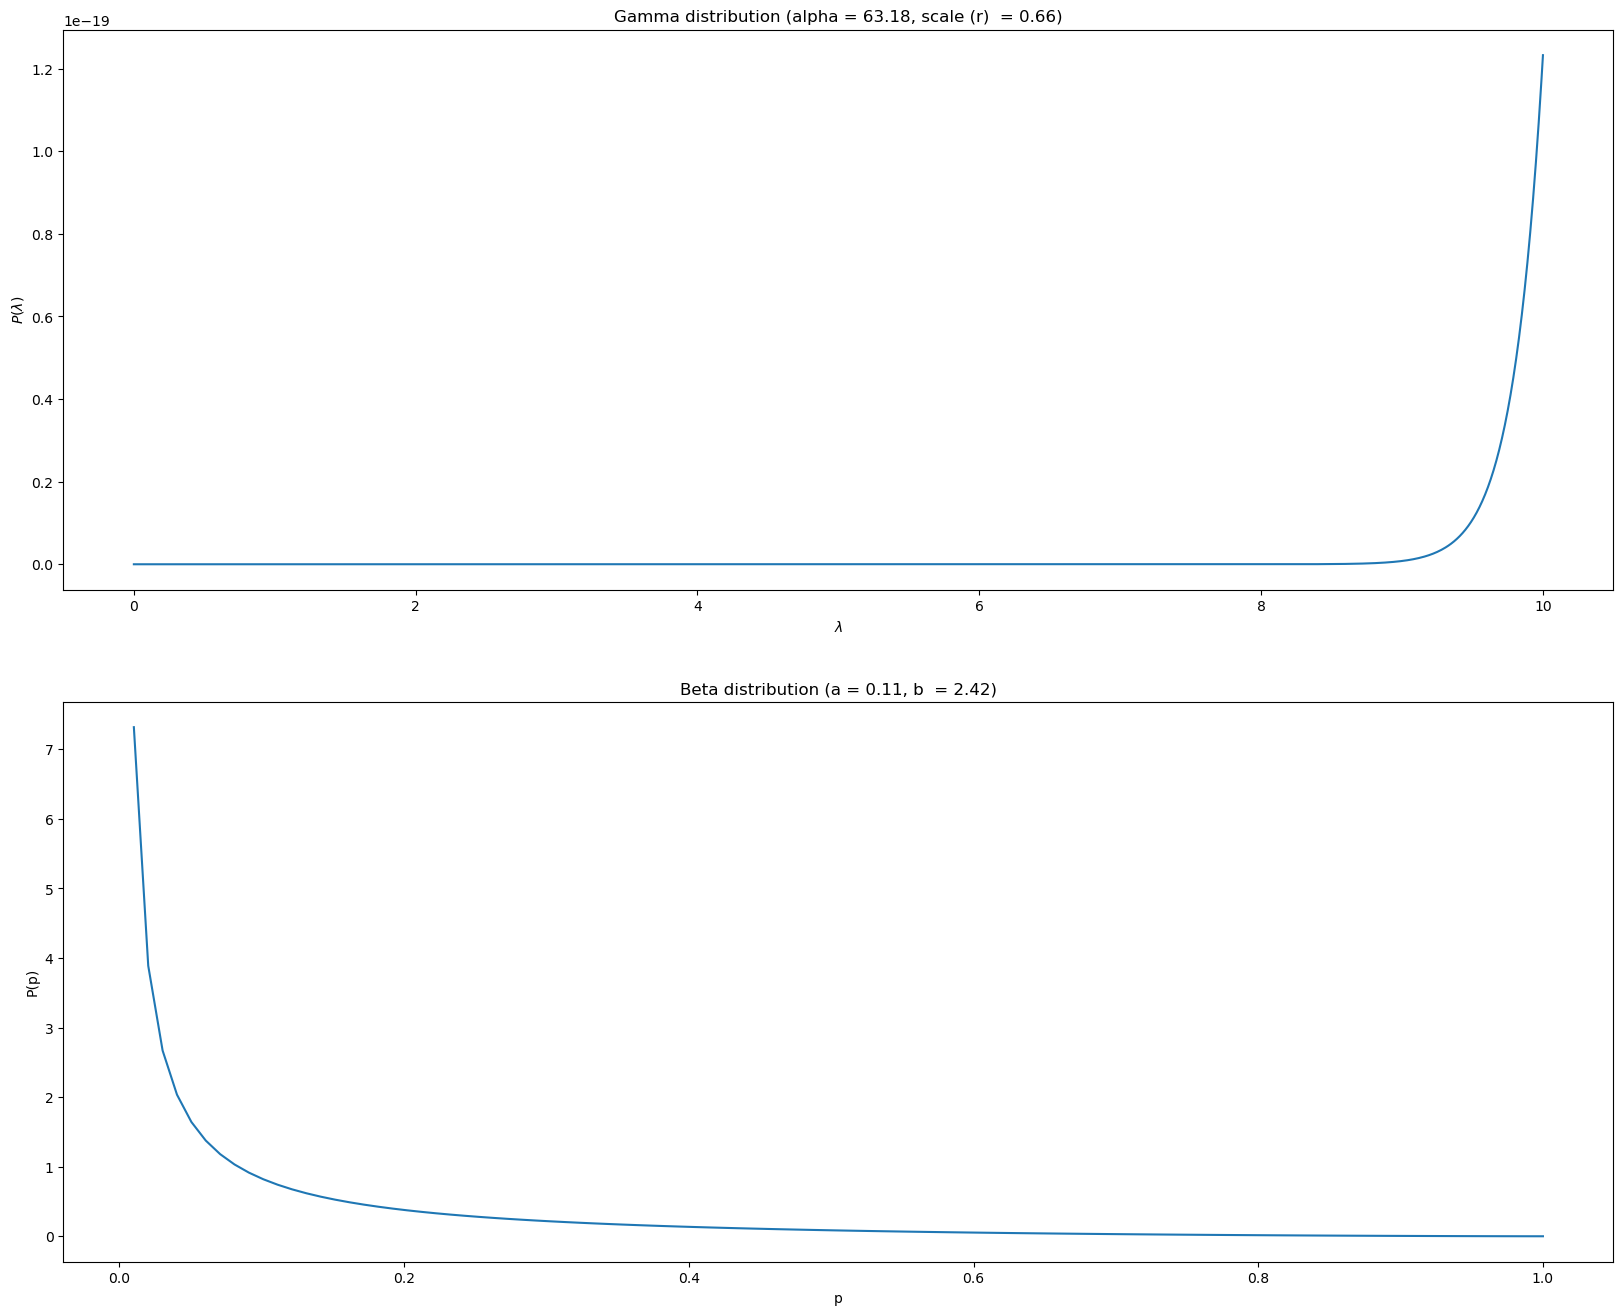

In [499]:
## GAMMA-GAMMA MODEL


import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt

fig, (ax_gamma, ax_beta) = plt.subplots(ncols=1, nrows =2, figsize = (20, 16))

x_gamma = np.linspace(0, 10, 1000)
y_gamma = stats.gamma.pdf(x_gamma, a=bgf.params_["alpha"], scale=bgf.params_["r"])
ax_gamma.plot(x_gamma, y_gamma, "-")
ax_gamma.set_title(f'Gamma distribution (alpha = {bgf.params_["alpha"]:.2f}, scale (r)  = {bgf.params_["r"]:.2f})')
ax_gamma.set_xlabel(r'$\lambda$')
ax_gamma.set_ylabel(r'$P(\lambda)$')


x_beta = np.linspace(0, 1, 100)
y_beta = stats.beta.pdf(x_beta, a=bgf.params_["a"], b=bgf.params_["b"])
ax_beta.plot(x_beta, y_beta, "-")
ax_beta.set_title(f'Beta distribution (a = {bgf.params_["a"]:.2f}, b  = {bgf.params_["b"]:.2f})')
ax_beta.set_xlabel('p')
ax_beta.set_ylabel('P(p)')
plt.show()


# GAMMA DISTRIBUTION
# From the plot, we can see that the Gamma distribution is relatively healthy, with most of the 𝜆 found near 2. 
# This means our customers are expected to shop at a rate of 2 transactions per week.

# BETA DISTRIBUTION
# The Beta distribution also seems healthy, with most of the p found near 0. 
# This implies that our customers are unlikely to deactivate soon.

In [500]:
# derive rfm; calculations set to weekly basis, predictions done later will be for future n weekly periods too

rfmggf = summary_data_from_transaction_data(transactions=df,
                                         customer_id_col='customerid',
                                         datetime_col='orderdt',
                                         monetary_value_col = 'orderamt',
                                         observation_period_end=pd.to_datetime('2011-12-09'),
                                         freq='W')


# Remove the one-time buyers. There is not enough history (only 1 data point/purchase) to use for prediction for future purchases.
# Based on the paper on BG/NBD model ("Counting Your Customers" the Easy Way, "the BG/NBD model forecasts tend to be relatively poor when penetration and/or purchase frequency are extremely low.
# In a world where active buyers are either uncommon or very slow in making their purchases, BG/NBD will be outperformed by the Pareto/NBD model. In this case, the one-time buyers (~28% of customers) were removed before fitting the models. 
# Pareto/NBD model should be fitted and compared.

rfmggf = rfmggf[rfmggf['frequency'] > 0]
rfmggf


,frequency,recency,T,monetary_value
customerid,,,,
12346,6.0,57.0,103.0,12907.160000
12347,7.0,58.0,58.0,717.398571
12348,4.0,51.0,62.0,449.310000
12349,3.0,82.0,84.0,1120.056667
12352,8.0,51.0,56.0,338.261250
...,...,...,...,...
18281,1.0,56.0,82.0,80.820000
18282,1.0,17.0,18.0,77.840000
18283,18.0,94.0,94.0,146.405556


In [501]:
# check if assumption for Gamma-Gamma model is satisfied
rfm = rfm[rfm['frequency'] > 0]


rfm[['frequency', 'monetary_value']].corr()

# The correlation between frequency is very low (0.034612). Thus, we can fit the model to the data. 

,frequency,monetary_value
frequency,1.000000,0.023223
monetary_value,0.023223,1.000000


In [502]:
from lifetimes import GammaGammaFitter


# fit the Gamma-Gamma model to our data_summary
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(frequency = rfm['frequency'], 
        monetary_value = rfm['monetary_value'])


<lifetimes.GammaGammaFitter: fitted with 4189 subjects, p: 11.71, q: 0.88, v: 11.69>

In [503]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,11.712306,0.225050,11.271208,12.153404
q,0.879022,0.016862,0.845973,0.912071
v,11.685864,0.230129,11.234810,12.136917


In [504]:
# Calculating the conditional expected average sales for each customer per transaction

rfm = rfm[rfm['monetary_value'] >0]

rfm['exp_avg_sales'] = ggf.conditional_expected_average_profit(rfm['frequency'],
                                       rfm['monetary_value'])
rfm.head()

,frequency,recency,T,monetary_value,p_alive,p_num_txn,exp_avg_sales
customerid,,,,,,,
12346,7.0,400.0,725.0,11066.637143,0.568660,0.17,11084.662943
12347,7.0,402.0,404.0,717.398571,0.986837,0.48,720.130596
12348,4.0,363.0,438.0,449.310000,0.959046,0.27,453.402277
12349,3.0,571.0,589.0,1120.056667,0.973475,0.16,1127.835134
12352,8.0,356.0,392.0,338.261250,0.976988,0.56,340.161178


In [505]:
# Checking the expected average value and the actual average value in the data to make sure the values are good
print(f"Expected Average Sales: {rfm['exp_avg_sales'].mean()}")
print(f"Actual Average Sales: {rfm['monetary_value'].mean()}")

Expected Average Sales: 454.7187959759485
Actual Average Sales: 447.6859962268581


In [506]:
# calculate LTV for each customer over the next 23 weeks with an assumed monthly discount rate of 0.01%
rfm['pred_CLV'] = ggf.customer_lifetime_value(bgf, 
                                                    rfm['frequency'], 
                                                    rfm['recency'], 
                                                    rfm['T'], 
                                                    rfm['monetary_value'],
                                                    time = 1,
                                                    freq = 'D',
                                                    discount_rate = 0.01)

rfm

,frequency,recency,T,monetary_value,p_alive,p_num_txn,exp_avg_sales,pred_CLV
customerid,,,,,,,,
12346,7.0,400.0,725.0,11066.637143,0.568660,0.17,11084.662943,1816.868552
12347,7.0,402.0,404.0,717.398571,0.986837,0.48,720.130596,345.144520
12348,4.0,363.0,438.0,449.310000,0.959046,0.27,453.402277,119.829052
12349,3.0,571.0,589.0,1120.056667,0.973475,0.16,1127.835134,182.768644
12352,8.0,356.0,392.0,338.261250,0.976988,0.56,340.161178,187.259020
...,...,...,...,...,...,...,...,...
18281,1.0,397.0,577.0,80.820000,0.927822,0.07,93.471340,6.677841
18282,1.0,119.0,126.0,77.840000,0.954346,0.25,90.460238,22.397124
18283,18.0,655.0,658.0,146.405556,0.993988,0.77,147.139205,112.178764


In [507]:
# Checking the manually calculated CLV based on predicted number of transaction from BG/NBD model and predicted avg sales from Gamma Gamma model and compared to the predicted CLV from Gamma Gamma model. Notice how close the values are. 
rfm['manual_predicted_clv'] = rfm['p_num_txn'] * rfm['exp_avg_sales']
rfm.head()

,frequency,recency,T,monetary_value,p_alive,p_num_txn,exp_avg_sales,pred_CLV,manual_predicted_clv
customerid,,,,,,,,,
12346,7.0,400.0,725.0,11066.637143,0.568660,0.17,11084.662943,1816.868552,1884.392700
12347,7.0,402.0,404.0,717.398571,0.986837,0.48,720.130596,345.144520,345.662686
12348,4.0,363.0,438.0,449.310000,0.959046,0.27,453.402277,119.829052,122.418615
12349,3.0,571.0,589.0,1120.056667,0.973475,0.16,1127.835134,182.768644,180.453621
12352,8.0,356.0,392.0,338.261250,0.976988,0.56,340.161178,187.259020,190.490260


In [508]:
rfm['churn'] = ['churned' if p_alive < 0.5 else
                            'not churned' for
                            p_alive in rfm['p_alive']]
rfm['churn'][(rfm['p_alive'] >= 0.5) & (rfm['p_alive'] < 0.75)] = "high risk"

rfm['churn'].value_counts()


not churned    3556
high risk       387
churned         246
Name: churn, dtype: int64

In [510]:
# identify our top 20 customers based on LTV
best_cust_LTV = rfm.sort_values('CLV').tail(20)
best_cust_LTV


,frequency,recency,T,monetary_value,p_alive,p_num_txn,exp_avg_sales,pred_CLV,manual_predicted_clv,churn,CLV
customerid,,,,,,,,,,,
14088,13.0,411.0,421.0,3949.358462,0.990077,0.84,3953.398536,3270.486754,3320.854770,not churned,163.524338
15769,39.0,721.0,728.0,2223.700513,0.996190,1.50,2224.589331,3293.303117,3336.883996,not churned,164.665156
14298,44.0,720.0,728.0,2023.197500,0.996247,1.68,2023.938213,3374.153102,3400.216197,not churned,168.707655
12931,42.0,717.0,738.0,2171.127143,0.992288,1.58,2171.939526,3402.090692,3431.664450,not churned,170.104535
16029,70.0,693.0,731.0,1699.404857,0.953623,2.54,1699.822622,4275.427395,4317.549459,not churned,213.771370
15311,195.0,738.0,738.0,594.605846,0.999447,7.31,594.697275,4302.913406,4347.237078,not churned,215.145670
13089,131.0,735.0,737.0,888.318779,0.998860,4.92,888.478039,4328.687788,4371.311950,not churned,216.434389
17949,70.0,736.0,737.0,1668.029714,0.998341,2.64,1668.442849,4360.407974,4404.689120,not churned,218.020399
15061,67.0,735.0,738.0,2008.116119,0.997957,2.52,2008.600193,5018.345680,5061.672486,not churned,250.917284


In [509]:
# CLV in terms of profit (profit margin is 5%)
profit_margin = 0.05
rfm['CLV'] = rfm['pred_CLV'] * profit_margin
rfm.head()

,frequency,recency,T,monetary_value,p_alive,p_num_txn,exp_avg_sales,pred_CLV,manual_predicted_clv,churn,CLV
customerid,,,,,,,,,,,
12346,7.0,400.0,725.0,11066.637143,0.568660,0.17,11084.662943,1816.868552,1884.392700,high risk,90.843428
12347,7.0,402.0,404.0,717.398571,0.986837,0.48,720.130596,345.144520,345.662686,not churned,17.257226
12348,4.0,363.0,438.0,449.310000,0.959046,0.27,453.402277,119.829052,122.418615,not churned,5.991453
12349,3.0,571.0,589.0,1120.056667,0.973475,0.16,1127.835134,182.768644,180.453621,not churned,9.138432
12352,8.0,356.0,392.0,338.261250,0.976988,0.56,340.161178,187.259020,190.490260,not churned,9.362951
